Maths for including a spatial correlations in the optical flow (SST) inversion algorithm

$$
\frac{\partial T}{\partial t} = -\frac{\partial T}{\partial x}u - \frac{\partial T}{\partial y}v + q
$$
$$
\mathbf{y} = \mathbf{H}\mathbf{x}+\varepsilon
$$

where

$$
\mathbf{y} = 
\begin{bmatrix}
	\frac{\partial T_1}{\partial t} \\ \vdots \\ \frac{\partial T_s}{\partial t}
\end{bmatrix}
$$

is the "observed" time-rate-of-change of SST at each spatial point.

- s - space index
- Size $[N\times 1]$. ($N$ is the total number of observations, number of spatial points times the number of coherent wavenumbers)

$$
\mathbf{H} = 
\begin{bmatrix}
    -\frac{\partial T_1}{\partial x} & \cdots & 0 & -\frac{\partial T_1}{\partial y} & \cdots & 0 & 1 & \cdots & 0 \\
   \vdots & \ddots & \vdots &  \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
   0 & \cdots & -\frac{\partial T_s}{\partial x} &  0 & \cdots & -\frac{\partial T_s}{\partial y} & 0 & \cdots & 1
\end{bmatrix}
$$
is the "operator" or incidence matrix i.e. the linear operator to go from model to observations. 

Size  $[3 \times S]$.



$$
\mathbf{x} = 
\begin{bmatrix}
	\begin{bmatrix}
	u_{1} \\ \vdots \\  u_{s}
	\end{bmatrix}
	\\
	\begin{bmatrix}
	v_{1} \\ \vdots \\ v_{s}
	\end{bmatrix}
     \\
    \begin{bmatrix}
	q_{1} \\ \vdots \\ q_{s}
	\end{bmatrix}
\end{bmatrix}
$$

contains the velocity and source term estimates .

The solution of $\mathbf{x}$ is (OI formula):

$$
\mathbf{x} = \mathbf{B}\mathbf{H}^T \left(\mathbf{H} \mathbf{B}\mathbf{H}^T + \mathbf{R}\right)^{-1}\mathbf{y}
$$

and the variance of the conditional distribution is:
$$
V[\mathbf{x}|\mathbf{y}] = \mathbf{B}\ - \mathbf{B}\mathbf{H}^T \left(\mathbf{H} \mathbf{B}\mathbf{H}^T + \mathbf{R}\right)^{-1}\mathbf{H}\mathbf{B}
$$
The model background covariance matrix $\mathbf{B}$ is

$$
\mathbf{B} =
\begin{bmatrix}
\mathbf{C}_{uu} & \mathbf{C}_{uv} & 0\\
\mathbf{C}_{vu} & \mathbf{C}_{vv} & 0\\
0 & 0 & \mathbf{C}_{qq}
\end{bmatrix}
$$ 
Size $[3S\times 3S]$

The error covariance matrix $\mathbf{R}$ is

$$
\mathbf{R} = \sigma^2\mathbf{I}
$$
where size $\mathbf{I}= [N\times N]$.

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43965")
client

<Client: 'tcp://127.0.0.1:43965' processes=4 threads=4, memory=15.62 GiB>

In [3]:
from scipy import sparse 
import numpy as np

import xarray as xr
import matplotlib.pyplot as plt

import sparse as dasksparse
from dask import array as da

from gptide import cov
import s3fs
import cmocean # Oceanography colour maps
from sfoda.utils.myproj import MyProj

In [35]:
# Load some SST data
time1 ='20240127'
time2 ='20240128'
time1 ='20240420'
time2 ='20240421'
time1 ='20240414'
time2 ='20240415'

time1 ='20230706'
time2 ='20230707'
year = 2024
area = [113, -23, 114.1, -21.5] # Ningaloo
region = 'ningaloo'

# time1 = '20230901'
# time2 = '20230902'
# year = 2023
# area = [119, -19.6, 120.2, -18.8] # NWS
# region = 'nws'

# time1 = '20230530'
# time2 = '20230531'
# year = 2023
# area = [122.2, -14.9, 123.2, -14] # NWS
# region = 'browse'
####


# Login to the s3 bucket and list the folders in the base directory of the imos-data/ bucket

fs = s3fs.S3FileSystem(anon=True) # Note that we can login anonymously because this bucket allows it

f1 = fs.glob('imos-data/IMOS/SRS/SST/ghrsst/L3C-1d/ngt/snpp/{}/{}*.nc'.format(year,time1))
f2 = fs.glob('imos-data/IMOS/SRS/SST/ghrsst/L3C-1d/ngt/snpp/{}/{}*.nc'.format(year,time2))


x1,x2=area[0], area[2]
y1,y2=area[1], area[3]

sst1 = xr.open_dataset(fs.open(f1[0]))\
    .sel(lon=slice(x1,x2), lat=slice(y2,y1))
sst2 = xr.open_dataset(fs.open(f2[0]))\
    .sel(lon=slice(x1,x2), lat=slice(y2,y1))



IndexError: list index out of range

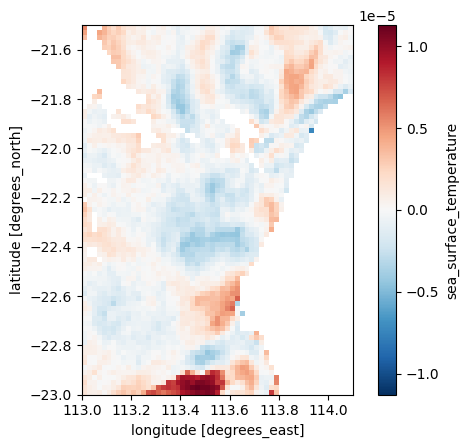

In [36]:
# Compute the gradients
dt = 86400.
dTdt = sst2['sea_surface_temperature'][0,...] - sst1['sea_surface_temperature'][0,...] 
dTdt /= dt

dTdy, dTdx = np.gradient(sst1['sea_surface_temperature'][0,...], 2000.)

idx = np.isnan(dTdt.values) | np.isnan(dTdx) | np.isnan(dTdy)

lon, lat = np.meshgrid(sst1['lon'], sst1['lat'])
P = MyProj(None, utmzone=49, isnorth=False)
Xm, Ym = P.to_xy(lon, lat)

dTdt.plot()
plt.gca().set_aspect('equal')

In [37]:
# Spatial B kernel input parameters
gpkernel = 'uv'
η_uv = 0.25 # m/s
ℓ_uv = 20e3 # m

gpkernel = 'helmholtz'
η_ψ = 500. # m^2/s
η_ϕ = 0. # m^2/s
ℓ_ψ = 5e3
ℓ_ϕ = 5e3

η_q = 1e-9
ℓ_q = 10e3 # m

# IID noise
noise = 1e-10



In [38]:

#Hlist = []
Hulist = []
Hvlist = []
Hqlist = []
ylist = []
XYlist = []
for ii in range(sst1.dims['lon']):
    for jj in range(sst1.dims['lat']):

        #if idx[jj,ii]: # NaN
        #    Hqlist.append([1.])
        #    Hulist.append([0.])
        #    Hvlist.append([0.])
        if ~idx[jj,ii]:
            Hqlist.append([1.])
            Hulist.append([dTdx[jj,ii]])
            Hvlist.append([dTdy[jj,ii]])     
            # Rotation-like operator
            #Hulist.append([-dTdy[jj,ii]])
            #Hvlist.append([dTdx[jj,ii]]) 
            ylist.append([dTdt.values[jj,ii]])

            XYlist.append([Xm[jj,ii], Ym[jj,ii]])
        
len(XYlist), len(ylist), len(Hulist)

(2748, 2748, 2748)

In [39]:
Nobsold = np.hstack(ylist).shape[0]
Nobsold

2748

In [40]:
# Append a dummy point so that we can have square chunks (cholesky needs this)
chunksize=1000
nextra = chunksize - Nobsold%chunksize

ydummy = 1e-7 #* np.ones((nextra,))

xend = XYlist[-1]
for ii in range(nextra):
    Hulist.append([ydummy])
    Hvlist.append([ydummy])
    Hqlist.append([ydummy])
    
    ylist.append([ydummy])
    XYlist.append([Xm[-1,-1], Ym[-1,-1]])

nextra

252

In [41]:
y = np.hstack(ylist).T
X = np.vstack(XYlist)

Nobs = y.shape[0]
Nx = X.shape[0]

X.shape, y.shape, Nx

((3000, 2), (3000,), 3000)

In [42]:
#H = sparse.block_diag(Hlist).tocsc()
Hu = sparse.block_diag(Hulist).tocsc()
Hv = sparse.block_diag(Hvlist).tocsc()
Hq = sparse.block_diag(Hqlist).tocsc()
H = sparse.hstack([Hu.T, Hv.T, Hq.T])
H,y.shape, Nobs

(<3000x9000 sparse matrix of type '<class 'numpy.float64'>'
 	with 8609 stored elements in Compressed Sparse Row format>,
 (3000,),
 3000)

In [43]:
Hs = dasksparse.COO.from_scipy_sparse(H)
Hs

Format,coo
Data Type,float64
Shape,"(3000, 9000)"
nnz,8609
Density,0.00031885185185185185
Read-only,True
Size,134.5K
Storage ratio,0.00


In [44]:
# Build "B" and "R" matrices
def matern32_2d(x, xpr, params):
    """
    2D kernel

    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            lx: x length scale
            ly: y length scale

    """
    eta, lx, ly = params

    # Build the covariance matrix
    C  = cov.matern32(x[:,1,None], xpr[:,1,None].T, ly)
    C *= cov.matern32(x[:,0,None], xpr[:,0,None].T, lx)
    C *= eta**2

    return C


In [45]:
# %%time
# covfunc = matern32_2d
# Buv = covfunc(X, X, (η_uv, ℓ_uv, ℓ_uv))

In [46]:
KernelHelmholtz2d?

Init signature: KernelHelmholtz2d(kernel='squared-exp')
Docstring:      <no docstring>
File:           ~/code/gphelmholtz/gphelmholtz/gphelmholtz.py
Type:           type
Subclasses:     

In [47]:
%%time
if gpkernel == 'helmholtz':
    from gphelmholtz import KernelHelmholtz2d
    covfunc = KernelHelmholtz2d(kernel='squared-exp')
    Bhelm = covfunc(X, X.T, (η_ψ, η_ϕ, ℓ_ψ, ℓ_ϕ,2,2))
    covfunc_q = matern32_2d
    Bq = covfunc_q(X, X, (η_q, ℓ_q, ℓ_q))
    B = sparse.block_diag([Bhelm, Bq]).tocsc()

elif gpkernel == 'uv':
    covfunc = matern32_2d
    Buv = covfunc(X, X, (η_uv, ℓ_uv, ℓ_uv))
    Bq = covfunc(X, X, (η_q, ℓ_q, ℓ_q))
    B = sparse.block_diag([Buv, Buv, Bq]).tocsc()

Bs = dasksparse.COO.from_scipy_sparse(B)
Bs

CPU times: user 6.43 s, sys: 1.37 s, total: 7.8 s
Wall time: 7.79 s


Format,coo
Data Type,float64
Shape,"(9000, 9000)"
nnz,45000000
Density,0.5555555555555556
Read-only,True
Size,686.6M
Storage ratio,1.11


In [48]:
Hd = da.from_array(Hs, chunks=chunksize)
Hd

dask.array<array, shape=(3000, 9000), dtype=float64, chunksize=(1000, 1000), chunktype=sparse.COO>

In [49]:
Bd = da.from_array(Bs, chunks=chunksize)
Bd

dask.array<array, shape=(9000, 9000), dtype=float64, chunksize=(1000, 1000), chunktype=sparse.COO>

In [50]:
yd = da.from_array(y, chunks=chunksize)
yd

dask.array<array, shape=(3000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

In [51]:
# IID noise "R" matrix
N = y.shape[0]
R = noise*sparse.eye(N).tocsc()

Rs = dasksparse.COO.from_scipy_sparse(R)
Rd = da.from_array(Rs, chunks=chunksize)
Rd

dask.array<array, shape=(3000, 3000), dtype=float64, chunksize=(1000, 1000), chunktype=sparse.COO>

In [52]:
# Linear algebra time
BHt = Bd@Hd.T
HBHt_R = Hd@BHt + Rd
HBHt_R
# linalg routines require dense matrices...
HBHt_R_dense = da.map_blocks(dasksparse.COO.todense, HBHt_R)
HBHt_R_dense

dask.array<todense, shape=(3000, 3000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [53]:
# Cholesky solve (faster)
L = da.linalg.cholesky(HBHt_R_dense, lower=True)
v = da.linalg.solve_triangular(L, yd, lower=True)
HBHt_R_1_y = da.linalg.solve_triangular(L.T, v, lower=False)
x_ = BHt @ HBHt_R_1_y


In [54]:
%%time
x_ = x_.compute()

/home/jupyter-mrayson/.local/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 85.88 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 204 ms, sys: 572 ms, total: 776 ms
Wall time: 28.4 s


In [55]:

outbias = x_[2*Nx:3*Nx]
u = x_[0:Nx]
v = x_[Nx:2*Nx]

0.16037888060553232


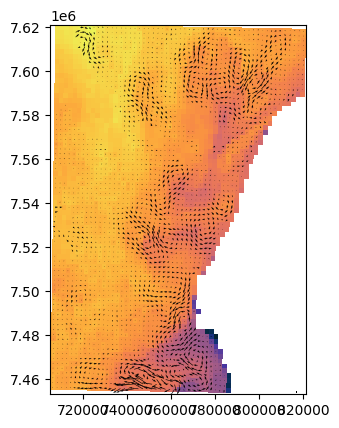

In [59]:
plt.figure()
ax=plt.subplot(111)
#plt.pcolormesh(Xm, Ym, sst1['sea_surface_temperature'][0,...], cmap='cmo.thermal')
plt.pcolormesh(Xm, Ym, sst2['sea_surface_temperature'][0,...], cmap='cmo.thermal')

#plt.pcolormesh(Xm, Ym, dTdt.values, cmap='RdBu')
plt.quiver(X[:,0], X[:,1], u, v, scale_units='xy', scale=2e-5)
ax.set_aspect('equal')
speed = np.abs(u+1j*v)
print(speed.max())
plt.savefig(f'FIGURES/sst_inversion_{gpkernel}_{region}_{time1}.png')

2.075174575585886e-12

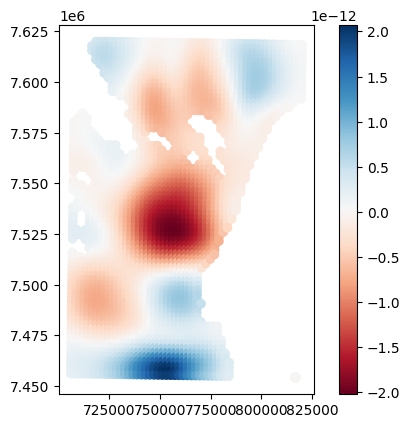

In [60]:
plt.figure()
ax=plt.subplot(111)
plt.scatter(X[:,0], X[:,1], c=outbias, cmap='RdBu')
ax.set_aspect('equal')
plt.colorbar()
outbias.max()

In [ ]:
gpkernel